In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
def calculate_eddy(width=500000, L=1e5, f0=None, rho0=1025, a=1., b=1.):
    if f0 is None:
        f0 = 2 * 7.29E-5 * np.sin(np.radians(-34))
    g = 9.81
    x = np.linspace(-width // 2, width // 2, 101)
    y = np.linspace(-width // 2, width // 2, 101)
    x_2d, y_2d = np.meshgrid(x, y, indexing='ij')
    
    x_c = 0
    y_c = 0
    # r_c = np.hypot(x_2d - x_c, y_2d - y_c)
    r_c = np.hypot((x_2d - x_c) / a, (y_2d - y_c) / b)
    
    sigma = -2 * np.exp(-r_c**2 / L**2)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    d_sigma_dx = np.gradient(sigma, axis=0) / dx
    d_sigma_dy = np.gradient(sigma, axis=1) / dy
    
    U = -g / f0 * d_sigma_dy
    V = g / f0 * d_sigma_dx
    
    return U, V, x/1000, y/1000

u, v, x, y = calculate_eddy()


In [3]:
def moca1(u, v, x, y, n_ic, n_jc, r=14):
    u1 = u[n_ic-r:n_ic+r+1, n_jc]
    v1 = v[n_ic-r:n_ic+r+1, n_jc]
    dx = x[1] - x[0]
    xx = x[n_ic-r:n_ic+r+1]
    yy = [y[n_jc]] * len(xx)
    l = xx - xx[0]
    coefficients = np.polyfit(l, v1, 1)
    c, b = coefficients
    a = np.polyfit(l, u1, 0)[0]
    x0 = - b / c
    y0 = a / c
    x0 += xx[0]
    y0 += yy[0]

    w = 2*c

    return x0, y0, l, xx, yy, u1, v1, a, b, c, w

In [4]:
nic = 50
njc = 60

nic2 = 50
njc2 = 54
r2 = 8

nic3 = 50
njc3 = 66
r3 = 20

x0, y0, l, xx, yy, u1, v1, a, b, c, w = moca1(u, v, x, y, nic, njc)

x02, y02, l2, xx2, yy2, u2, v2, a2, b2, c2, w2  = moca1(u, v, x, y, nic2, njc2) # closest 
x03, y03, l3, xx3, yy3, u3, v3, a3, b3, c3, w3  = moca1(u, v, x, y, nic3, njc3) # furthest

x02_r, y02_r, l2_r, xx2_r, yy2_r, u2_r, v2_r, a2_r, b2_r, c2_r, w2_r  = moca1(u, v, x, y, nic, njc, r2) # shortest
x03_r, y03_r, l3_r, xx3_r, yy3_r, u3_r, v3_r, a3_r, b3_r, c3_r, w3_r  = moca1(u, v, x, y, nic, njc, r3) # longest


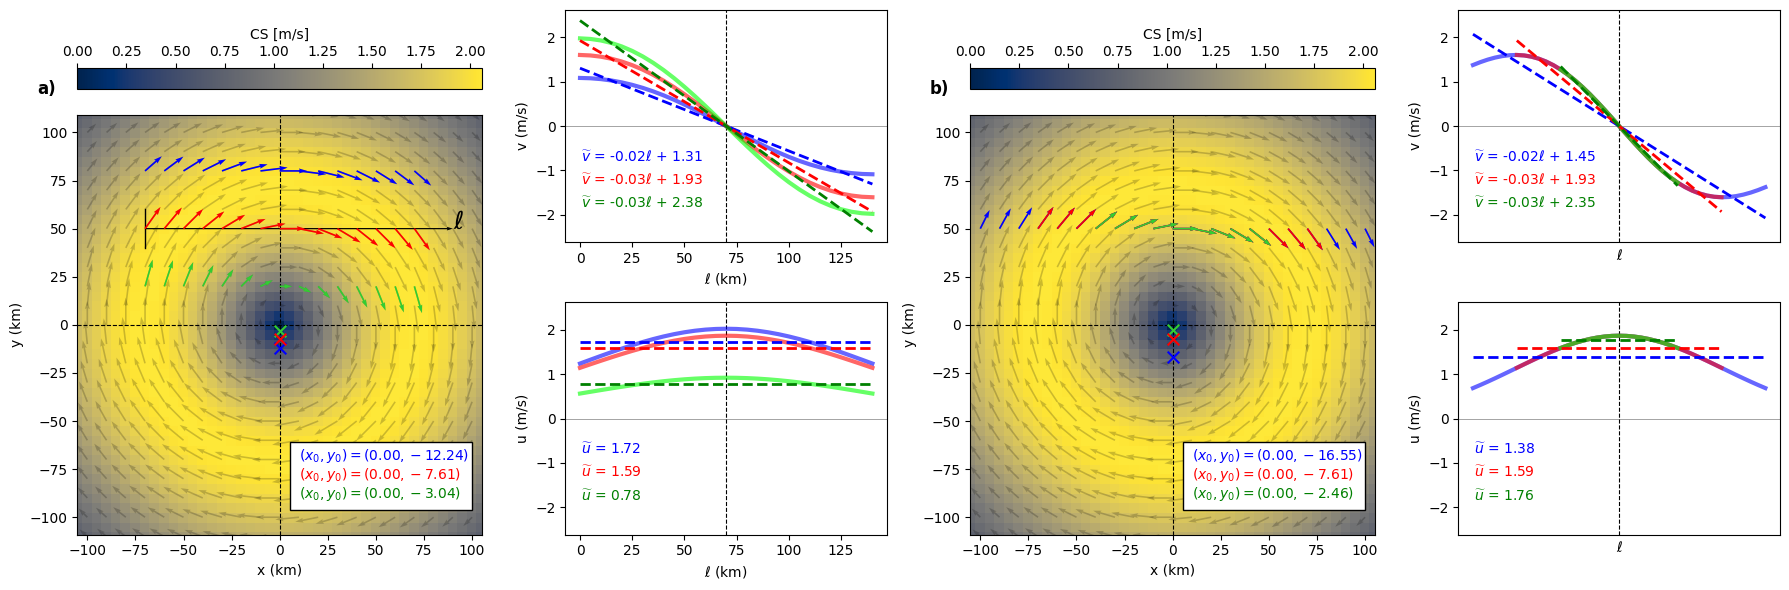

In [6]:
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(2, 6, figure=fig, width_ratios=[1, 1, 2, 1, 1, 2])  # Adjust width ratios

# LEFT PLOT (PLOT A)
ax_main_left = fig.add_subplot(gs[:, :2])
pc = ax_main_left.pcolor(x, y, np.hypot(u, v), cmap='cividis')
ax_main_left.axhline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)
ax_main_left.axvline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)

spacing = 2
scale = 30
width = 0.004
alpha = 1
quiv = ax_main_left.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, alpha=.2, scale=scale, width=width)

# l axis
ax_main_left.quiver(xx[0], yy[0], xx[-1] - xx[0] + 20, yy[-1] - yy[0], angles='xy', scale_units='xy', scale=1, color='k', width=0.003, zorder=1)
ax_main_left.plot([xx[0], xx[0]], [yy[0] - 10, yy[0] + 10], color='k', linewidth=1)
ax_main_left.text(xx[-1] + 20, yy[0], r'$\ell$', fontsize=18)

ax_main_left.quiver(xx[::spacing], yy[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width, color='r', zorder=3)
ax_main_left.scatter(x0, y0, color='r', marker='x', s=70, label='MOCA Result', zorder=4)
ax_main_left.quiver(xx2[::spacing], yy2[::spacing], u2[::spacing], v2[::spacing], scale=scale, width=width, color='limegreen', zorder=3, alpha=alpha)
ax_main_left.scatter(x02, y02, color='limegreen', marker='x', s=70, zorder=3, alpha=alpha)
ax_main_left.quiver(xx3[::spacing], yy3[::spacing], u3[::spacing], v3[::spacing], scale=scale, width=width, color='b', zorder=3, alpha=alpha)
ax_main_left.scatter(x03, y03, color='b', marker='x', s=70, zorder=3, alpha=alpha)
plt.colorbar(pc, ax=ax_main_left, orientation='horizontal', location='top', label='CS [m/s]')

x_pos, y_pos = 0.75, 0.14
box_width = 0.45  # Adjust width as needed
box_height = 0.16 #0.07  # Adjust height as needed
rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main_left.transAxes,
                       facecolor='white', edgecolor='black')
ax_main_left.add_patch(rect)

ax_main_left.text(10 , -70, fr'$(x_0,y_0)=({x03:.2f},{y03:.2f})$', color='b')
ax_main_left.text(10 , -80, fr'$(x_0,y_0)=({x0:.2f},{y0:.2f})$', color='r')
ax_main_left.text(10 , -90, fr'$(x_0,y_0)=({x02:.2f},{y02:.2f})$', color='g')

ax_main_left.axis('equal')
ax_main_left.set_xlim(-100, 100)
ax_main_left.set_ylim(-100, 100)
ax_main_left.set_xlabel('x (km)')
ax_main_left.set_ylabel('y (km)')
ax_main_left.text(-0.1, 1.05, 'a)', transform=ax_main_left.transAxes, fontsize=12, fontweight='bold')

# Subplot columns (2x1 on the right)
ax2_left = fig.add_subplot(gs[0, 2])
ax3_left = fig.add_subplot(gs[1, 2])

d1, d2, d3 = l3 + xx3[0] - xx[0], l, l2 + xx2[0] - xx[0]
fit1 = np.poly1d(np.polyfit(d1, v3, 1))
fit2 = np.poly1d(np.polyfit(d2, v1, 1))
fit3 = np.poly1d(np.polyfit(d3, v2, 1))
ax2_left.axvline(d1[len(d1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax2_left.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax2_left.plot(d1, v3, color=(0, 0, 1, 0.6), linewidth=3)
ax2_left.plot(d2, v1, color=(1, 0, 0, 0.6), linewidth=3)
ax2_left.plot(d3, v2, color=(0, 1, 0, 0.6), linewidth=3)
ax2_left.plot(d1, fit1(d1), color='b', linestyle='--', linewidth=2)  # Light blue for fit1
ax2_left.plot(d2, fit2(d2), color='r', linestyle='--', linewidth=2)  # Light red for fit2
ax2_left.plot(d3, fit3(d3), color='g', linestyle='--', linewidth=2)  # Light green for fit3
ax2_left.text(0.05, 0.4, fr"$\widetilde{{v}}$ = {fit1[1]:.2f}$\ell$ + {fit1[0]:.2f}", transform=ax2_left.transAxes,
         fontsize=10, verticalalignment='top', color='b')
ax2_left.text(0.05, 0.3, fr"$\widetilde{{v}}$ = {fit2[1]:.2f}$\ell$ + {fit2[0]:.2f}", transform=ax2_left.transAxes,
         fontsize=10, verticalalignment='top', color='r')
ax2_left.text(0.05, 0.2, fr"$\widetilde{{v}}$ = {fit3[1]:.2f}$\ell$ + {fit3[0]:.2f}", transform=ax2_left.transAxes,
         fontsize=10, verticalalignment='top', color='g')
ax2_left.set_ylabel('v (m/s)')
ax2_left.set_xlabel(r'$\ell$ (km)')
# ax2_left.set_xticks([])

d1, d2, d3 = l3 + xx3[0] - xx[0], l, l2 + xx2[0] - xx[0]
fit1 = np.poly1d(np.polyfit(d1, u3, 0))
fit2 = np.poly1d(np.polyfit(d2, u1, 0))
fit3 = np.poly1d(np.polyfit(d3, u2, 0))
ax3_left.axvline(d1[len(d1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax3_left.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax3_left.plot(d1, u3, color=(0, 0, 1, 0.6), linewidth=3)
ax3_left.plot(d2, u1, color=(1, 0, 0, 0.6), linewidth=3)
ax3_left.plot(d3, u2, color=(0, 1, 0, 0.6), linewidth=3)
ax3_left.plot(d1, fit1(d1), color='b', linestyle='--', linewidth=2)  # Light blue for fit1
ax3_left.plot(d2, fit2(d2), color='r', linestyle='--', linewidth=2)  # Light red for fit2
ax3_left.plot(d3, fit3(d3), color='g', linestyle='--', linewidth=2)  # Light green for fit3
ax3_left.text(0.05, 0.4, fr"$\widetilde{{u}}$ = {fit1[0]:.2f}", transform=ax3_left.transAxes,
         fontsize=10, verticalalignment='top', color='b')
ax3_left.text(0.05, 0.3, fr"$\widetilde{{u}}$ = {fit2[0]:.2f}", transform=ax3_left.transAxes,
         fontsize=10, verticalalignment='top', color='r')
ax3_left.text(0.05, 0.2, fr"$\widetilde{{u}}$ = {fit3[0]:.2f}", transform=ax3_left.transAxes,
         fontsize=10, verticalalignment='top', color='g')
ax3_left.set_ylabel('u (m/s)')
ax3_left.set_xlabel(r'$\ell$ (km)')
# ax3_left.set_xticks([])

ymin1, ymax1 = ax2_left.get_ylim()
ymin2, ymax2 = ax3_left.get_ylim()

ymin = min(ymin1, ymin2)
ymax = max(ymax1, ymax2)

ax2_left.set_ylim(ymin, ymax)
ax3_left.set_ylim(ymin, ymax)

# RIGHT PLOT (PLOT B)
ax_main_right = fig.add_subplot(gs[:, 3:5])
pc = ax_main_right.pcolor(x, y, np.hypot(u, v), cmap='cividis')
ax_main_right.axhline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)
ax_main_right.axvline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)

quiv = ax_main_right.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, alpha=.2, scale=scale, width=width)
ax_main_right.quiver(xx3_r[::spacing], yy3_r[::spacing], u3_r[::spacing], v3_r[::spacing], scale=scale, width=width, color='b', zorder=3, alpha=alpha)
ax_main_right.scatter(x03_r, y03_r, color='b', marker='x', s=70, zorder=3, alpha=alpha)
ax_main_right.quiver(xx[::spacing], yy[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width, color='r', zorder=3)
ax_main_right.scatter(x0, y0, color='r', marker='x', s=70, label='MOCA Result', zorder=4)
ax_main_right.quiver(xx2_r[::spacing], yy2_r[::spacing], u2_r[::spacing], v2_r[::spacing], scale=scale, width=width, color='limegreen', zorder=5, alpha=alpha)
ax_main_right.scatter(x02_r, y02_r, color='limegreen', marker='x', s=70, zorder=3, alpha=alpha)
plt.colorbar(pc, ax=ax_main_right, orientation='horizontal', location='top', label='CS [m/s]')

rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main_right.transAxes,
                       facecolor='white', edgecolor='black')
ax_main_right.add_patch(rect)

ax_main_right.text(10 , -70, fr'$(x_0,y_0)=({round(x03_r):.2f},{y03_r:.2f})$', color='b')
ax_main_right.text(10 , -80, fr'$(x_0,y_0)=({round(x0):.2f},{y0:.2f})$', color='r')
ax_main_right.text(10 , -90, fr'$(x_0,y_0)=({round(x02_r):.2f},{y02_r:.2f})$', color='g')

ax_main_right.axis('equal')
ax_main_right.set_xlim(-100, 100)
ax_main_right.set_ylim(-100, 100)
ax_main_right.set_xlabel('x (km)')
ax_main_right.set_ylabel('y (km)')
ax_main_right.text(-0.1, 1.05, 'b)', transform=ax_main_right.transAxes, fontsize=12, fontweight='bold')

# Subplot columns (2x1 on the right)
ax2_right = fig.add_subplot(gs[0, 5])
ax3_right = fig.add_subplot(gs[1, 5])

d1, d2, d3 = l3_r + xx3_r[0] - xx[0], l, l2_r + xx2_r[0] - xx[0]
fit1 = np.poly1d(np.polyfit(d1, v3_r, 1))
fit2 = np.poly1d(np.polyfit(d2, v1, 1))
fit3 = np.poly1d(np.polyfit(d3, v2_r, 1))
ax2_right.axvline(d1[len(d1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax2_right.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax2_right.plot(d1, v3_r, color=(0, 0, 1, 0.6), linewidth=3)
ax2_right.plot(d2, v1, color=(1, 0, 0, 0.6), linewidth=3)
ax2_right.plot(d3, v2_r, color=(0, 1, 0, 0.6), linewidth=3)
ax2_right.plot(d1, fit1(d1), color='b', linestyle='--', linewidth=2)  # Light blue for fit1
ax2_right.plot(d2, fit2(d2), color='r', linestyle='--', linewidth=2)  # Light red for fit2
ax2_right.plot(d3, fit3(d3), color='g', linestyle='--', linewidth=2)  # Light green for fit3
ax2_right.text(0.05, 0.4, fr"$\widetilde{{v}}$ = {fit1[1]:.2f}$\ell$ + {fit1[0]:.2f}", transform=ax2_right.transAxes,
         fontsize=10, verticalalignment='top', color='b')
ax2_right.text(0.05, 0.3, fr"$\widetilde{{v}}$ = {fit2[1]:.2f}$\ell$ + {fit2[0]:.2f}", transform=ax2_right.transAxes,
         fontsize=10, verticalalignment='top', color='r')
ax2_right.text(0.05, 0.2, fr"$\widetilde{{v}}$ = {fit3[1]:.2f}$\ell$ + {fit3[0]:.2f}", transform=ax2_right.transAxes,
         fontsize=10, verticalalignment='top', color='g')
ax2_right.set_ylabel('v (m/s)')
ax2_right.set_xlabel(r'$\ell$')
ax2_right.set_xticks([])

d1, d2, d3 = l3_r + xx3_r[0] - xx[0], l, l2_r + xx2_r[0] - xx[0]
fit1 = np.poly1d(np.polyfit(d1, u3_r, 0))
fit2 = np.poly1d(np.polyfit(d2, u1, 0))
fit3 = np.poly1d(np.polyfit(d3, u2_r, 0))
ax3_right.axvline(d1[len(d1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax3_right.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax3_right.plot(d1, u3_r, color=(0, 0, 1, 0.6), linewidth=3)
ax3_right.plot(d2, u1, color=(1, 0, 0, 0.6), linewidth=3)
ax3_right.plot(d3, u2_r, color=(0, 1, 0, 0.6), linewidth=3)
ax3_right.plot(d1, fit1(d1), color='b', linestyle='--', linewidth=2)  # Light blue for fit1
ax3_right.plot(d2, fit2(d2), color='r', linestyle='--', linewidth=2)  # Light red for fit2
ax3_right.plot(d3, fit3(d3), color='g', linestyle='--', linewidth=2)  # Light green for fit3

ax3_right.text(0.05, 0.4, fr"$\widetilde{{u}}$ = {fit1[0]:.2f}", transform=ax3_right.transAxes,
         fontsize=10, verticalalignment='top', color='b')
ax3_right.text(0.05, 0.3, fr"$\widetilde{{u}}$ = {fit2[0]:.2f}", transform=ax3_right.transAxes,
         fontsize=10, verticalalignment='top', color='r')
ax3_right.text(0.05, 0.2, fr"$\widetilde{{u}}$ = {fit3[0]:.2f}", transform=ax3_right.transAxes,
         fontsize=10, verticalalignment='top', color='g')

ax3_right.set_ylabel('u (m/s)')
ax3_right.set_xlabel(r'$\ell$')
ax3_right.set_xticks([])

# ymin1, ymax1 = ax2_right.get_ylim()
# ymin2, ymax2 = ax3_right.get_ylim()

# ymin = min(ymin1, ymin2)
# ymax = max(ymax1, ymax2)

ax2_right.set_ylim(ymin, ymax)
ax3_right.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()